In [265]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sn
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


In [ ]:
data = pd.read_csv("C:\\Users\\Leni\\Documents\\UNI\\Data Challenges\\data\\analysis_dataset.csv", sep=";")
coin_ids = data['coin']
del data["coin"]
del data["findspot"] #empty column
del data["Unnamed: 0"]
del data["mindiam"]
features = data.columns #column names
index = data.index


print("data raw")
data

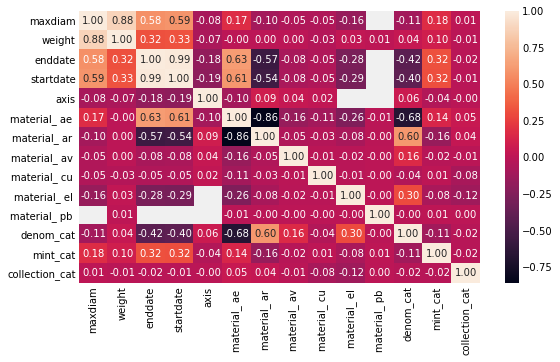

In [259]:
corrMatrix = data.corr()
plt.figure(figsize=(8, 5))
sn.heatmap(corrMatrix, annot=True, fmt='.2f')

plt.show()

#### Daten skalieren

In [207]:
# scale numeric data, MW 0 Std 1
scaler = StandardScaler()
scal_data = pd.DataFrame(scaler.fit_transform(data), columns = features, index = index) #ndarray, nan 

# TODO: handle categorical data?

print("data scaled")
scal_data


data scaled


,maxdiam,weight,enddate,startdate,axis,material_ ae,material_ ar,material_ av,material_ cu,material_ el,material_ pb,denom_cat,mint_cat,collection_cat
0,-0.413940,-0.647980,0.744287,0.743718,NaN,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.504778,0.957684,-1.455965
1,NaN,0.979059,0.865853,0.925395,NaN,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.307209,0.957684,-1.455878
2,NaN,-0.786664,NaN,NaN,NaN,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.636490,-0.451951,-0.496492
3,-1.439515,-0.999695,-1.377243,-1.195409,NaN,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,0.087929,-0.691889,0.462895
4,0.500762,NaN,1.089378,1.136734,NaN,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.373065,0.477808,-1.456051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,-1.550388,-0.776656,-2.043897,-1.992564,NaN,-1.652327,-0.519417,-0.097511,-0.064075,6.28655,-0.004933,1.931904,-0.481943,1.155905
41084,-1.647402,NaN,-0.408633,-0.561392,NaN,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,0.087929,0.867708,1.155991
41085,-1.688979,-0.971100,-1.749785,-1.807179,NaN,-1.652327,-0.519417,-0.097511,-0.064075,6.28655,-0.004933,2.656322,-0.481943,-1.456051
41086,NaN,0.191275,0.963890,1.014380,NaN,-1.652327,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.373065,1.647506,1.156078


#### Imputieren von fehlenden Werten mit iterativem Imputer (gleich dbscan)

In [208]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp_data = scal_data.copy()
head = scal_data.columns
for col in scal_data.columns:
    imp.fit(np.array(scal_data[col]).reshape(-1,1))
    imp_data[col] = imp.transform(np.array(scal_data[col]).reshape(-1,1))
imp_data = pd.DataFrame(imp_data, columns=head)

print("data imputed")
imp_data

data imputed


,maxdiam,weight,enddate,startdate,axis,material_ ae,material_ ar,material_ av,material_ cu,material_ el,material_ pb,denom_cat,mint_cat,collection_cat
0,-4.139399e-01,-6.479800e-01,7.442866e-01,7.437175e-01,1.315543e-16,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.504778,0.957684,-1.455965
1,-9.260356e-17,9.790586e-01,8.658530e-01,9.253948e-01,1.315543e-16,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.307209,0.957684,-1.455878
2,-9.260356e-17,-7.866643e-01,9.917526e-18,5.289665e-17,1.315543e-16,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.636490,-0.451951,-0.496492
3,-1.439515e+00,-9.996949e-01,-1.377243e+00,-1.195409e+00,1.315543e-16,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,0.087929,-0.691889,0.462895
4,5.007624e-01,-1.128117e-16,1.089378e+00,1.136734e+00,1.315543e-16,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.373065,0.477808,-1.456051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,-1.550388e+00,-7.766562e-01,-2.043897e+00,-1.992564e+00,1.315543e-16,-1.652327,-0.519417,-0.097511,-0.064075,6.28655,-0.004933,1.931904,-0.481943,1.155905
41084,-1.647402e+00,-1.128117e-16,-4.086333e-01,-5.613924e-01,1.315543e-16,0.605207,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,0.087929,0.867708,1.155991
41085,-1.688979e+00,-9.711002e-01,-1.749785e+00,-1.807179e+00,1.315543e-16,-1.652327,-0.519417,-0.097511,-0.064075,6.28655,-0.004933,2.656322,-0.481943,-1.456051
41086,-9.260356e-17,1.912745e-01,9.638904e-01,1.014380e+00,1.315543e-16,-1.652327,-0.519417,-0.097511,-0.064075,-0.15907,-0.004933,-0.373065,1.647506,1.156078


##### optimal number of Clusters 

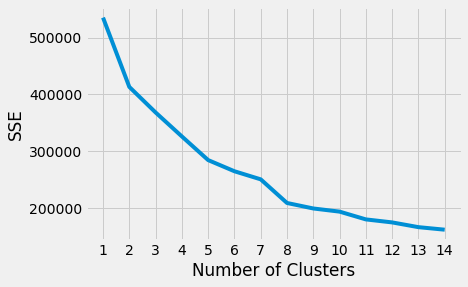

8

In [124]:
max_clusters = 15

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,}

sse = []
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(imp_data)
    sse.append(kmeans.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, max_clusters), sse)
plt.xticks(range(1, max_clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#elbow point
kl = KneeLocator(
    range(1, max_clusters), sse, curve="convex", direction="decreasing"
)

print("elbow point KneeLocator: ", kl.elbow)

### kMeans

In [209]:
kmeans = KMeans(
    init="random",
    n_clusters=8,
    n_init=10,
    max_iter=300,
    random_state=42
)

#imp_data = imp_data.to_numpy()
kmeans.fit(imp_data)
labels = kmeans.labels_

print("min SSE:", kmeans.inertia_ )
print("#iterations: ", kmeans.n_iter_)
#print("cluster centers: ", kmeans.cluster_centers_)
print(kmeans.labels_)




min SSE: 224134.18485864668
#iterations:  40
[3 3 2 ... 1 7 2]


In [ ]:
#### explore clustered dataset

In [220]:
print(pd.DataFrame(kmeans.labels_)[0].value_counts())

data['labels'] = labels
data_agg = data.groupby("labels").agg(["mean", "count"])
print(data_agg)

3    9497
7    9060
2    8277
6    5212
4    4119
0    3522
1    1014
5     387
Name: 0, dtype: int64
          maxdiam           weight           enddate         startdate        \
             mean count       mean count        mean count        mean count   
labels                                                                         
0       28.286173  2503  15.269184  3384 -210.907927  2813 -251.375178  2812   
1       14.908691   955   9.343892   740 -443.631966   951 -513.123028   951   
2       15.383618  6322   3.878250  7605 -237.609201  6717 -300.817925  6717   
3       22.840582  7012   7.179161  6736  184.182153  7867  163.252066  7867   
4       32.453678  3670  20.619098  3960  204.712355  3699  195.476886  3699   
5       17.811957   276   8.275081   370 -282.384615   234 -319.444444   234   
6       14.425599  3758   3.134510  4858 -365.409655  4350 -399.007126  4350   
7       21.885724  6426   6.549431  7713  164.760473  6684  139.686668  6683   

            axis 

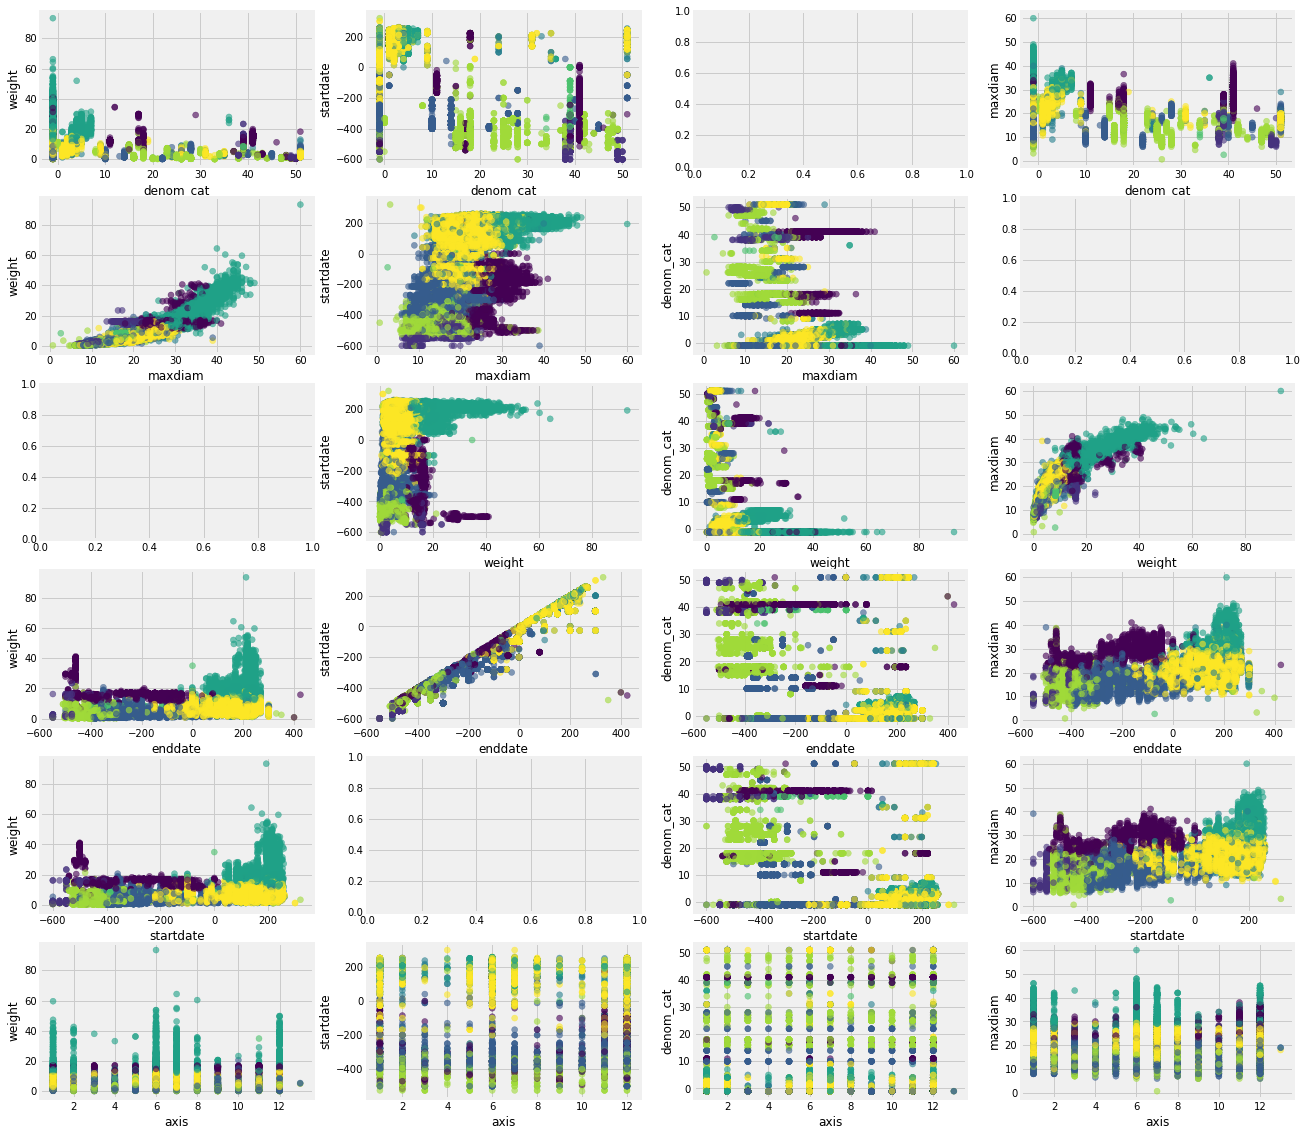

In [246]:
#'maxdiam', 'weight', 'enddate', 'startdate', 'axis',
#'material_ ae ','material_ ar ', 'material_ av ', 'material_ cu ', 'material_ el ', #'material_ pb ', 
#'denom_cat', 'mint_cat', 'collection_cat']


features_anal1 = ['denom_cat', 'maxdiam', 'weight','enddate', 'startdate', 'axis', ]#,'denom_cat', 'mint_cat', 'collection_cat' ]
features_anal2 = ['weight', 'startdate', 'denom_cat', 'maxdiam']
fig, axs = plt.subplots(len(features_anal1), len(features_anal2), sharex=False, sharey=False, figsize=(20, 20))
y, x = 0, 0

for feature1 in features_anal1:
    for feature2 in features_anal2:
        if not feature1 == feature2:
            axs[x, y].scatter(data[feature1], data[feature2], c=data['labels'], alpha=0.6)
            axs[x, y].set_xlabel(feature1)
            axs[x, y].set_ylabel(feature2)
        y += 1
    y = 0
    x += 1

plt.show()


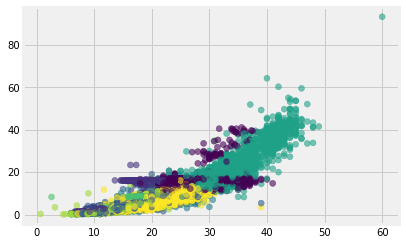

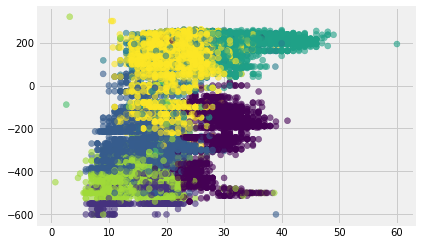

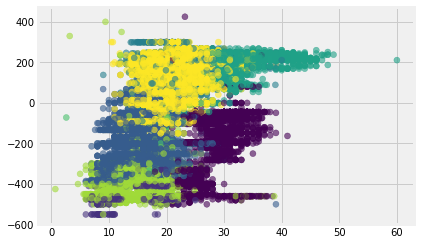

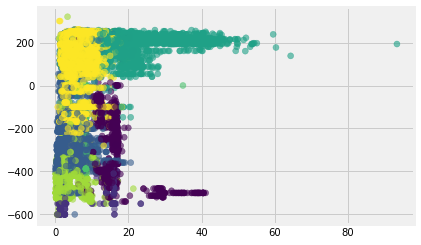

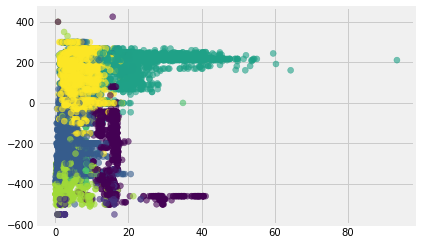

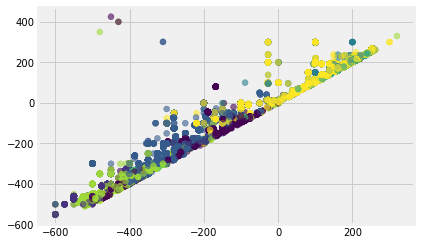

In [245]:
plt.scatter(data['maxdiam'], data.weight, c=data.labels, alpha = 0.6)
plt.show()
plt.scatter(data.maxdiam, data.startdate, c=data.labels, alpha = 0.6)
plt.show()
plt.scatter(data.maxdiam, data.enddate, c=data.labels, alpha = 0.6)
plt.show()
plt.scatter(data.weight, data.startdate, c=data.labels, alpha = 0.6)
plt.show()
plt.scatter(data.weight, data.enddate, c=data.labels, alpha = 0.6)
plt.show()
plt.scatter(data.startdate, data.enddate, c=data.labels, alpha = 0.6)
plt.show()

### kModes
The k-prototypes also accepts np.NaN values as missing values for the categorical variables, but does not accept missing values for the numerical values. 

In [268]:
kproto = KPrototypes(n_clusters=8, init='Cao', verbose=0)
clusters = kproto.fit_predict(imp_data, categorical=[11, 12, 13]) #column indices that are categorical 


print("min SSE:", kmodes.inertia_ )
print("#iterations: ", kmodes.n_iter_)
#print("cluster centers: ", kmeans.cluster_centers_)
print(kproto.labels_)

NameError: name 'kmodes' is not defined

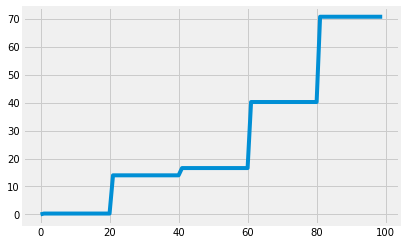

In [269]:
# Münzen mit vielen fehlenden Werten rauswerfen? 
filled = 9 # number of dummy, cat variables
fill_ratio = 100 - data.isnull().sum(axis = 1) / (len(data.columns)- filled) * 100 

#fill_ratio.hist() #als histogram anschauen

filled = []
for i in range(100):
    filled.append(fill_ratio[fill_ratio < i].count() / len(fill_ratio) * 100)

plt.plot(range(100), filled)
plt.show()

 

In [ ]:
# Gibt es Korrelationen zwischen einzelnen Attributen? bspw. Material und ming?

In [19]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      41088 non-null  int64  
 1   coin            41088 non-null  float64
 2   maxdiam         30922 non-null  float64
 3   mindiam         18346 non-null  float64
 4   weight          35366 non-null  float64
 5   enddate         33315 non-null  float64
 6   startdate       33313 non-null  float64
 7   axis            14259 non-null  float64
 8   material_ ae    41088 non-null  float64
 9   material_ ar    41088 non-null  float64
 10  material_ av    41088 non-null  float64
 11  material_ cu    41088 non-null  float64
 12  material_ el    41088 non-null  float64
 13  material_ pb    41088 non-null  float64
 14  denom_cat       41088 non-null  float64
 15  mint_cat        41088 non-null  float64
 16  collection_cat  41088 non-null  float64
dtypes: float64(16), int64(1)
memory

,Unnamed: 0,coin,maxdiam,mindiam,weight,enddate,startdate,axis,material_ ae,material_ ar,material_ av,material_ cu,material_ el,material_ pb,denom_cat,mint_cat,collection_cat
0,0,31084.0,18.4,17.9,3.58,161.0,138.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,86.0,0.0
1,1,13239.0,NaN,NaN,14.96,192.0,187.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,4.0,86.0,1.0
2,2,24329.0,NaN,NaN,2.61,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,39.0,11112.0
3,3,36245.0,11.0,NaN,1.12,-380.0,-385.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,10.0,31.0,22223.0
4,4,8127.0,25.0,24.0,NaN,249.0,244.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,3.0,70.0,-1.0
